Enable auto-reloading of external modules

In [368]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import dependencies

In [369]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sys import getsizeof

from utils.data_loader import *
from utils.null_handler import *
from utils.EDA_utils import *

import warnings
warnings.filterwarnings('ignore')

SEED=10
plt.style.use('mpl20')
matplotlib.rcParams['figure.dpi'] = 100
# figure size in inches
rcParams['figure.figsize'] = 8, 8
sns.set_style("darkgrid")

In [370]:
try:
    from folktables import ACSDataSource, ACSEmployment
except:
    !pip install folktables
    from folktables import ACSDataSource, ACSEmployment

### Loading ACSEmployment data

In [371]:
config = {
    'state': ["NY"],
    'year': '2018',
    'task': ACSEmployment
}

In [372]:
X_data_load, y_data = ACSDataLoader(task=config['task'], state=config['state'], year=config['year'])

In [373]:
# If the task is ACSEmployment, we can optimize the file size
print(f'Original: {int(getsizeof(X_data_load) / 1024**2)} mb')
print(f'Optimized: {int(getsizeof(optimize_ACSEmployment(X_data_load)) / 1024**2)} mb')

X_data = optimize_ACSEmployment(X_data_load)

Original: 45 mb
Optimized: 23 mb


In [ ]:
missing = ['SCHL', 'ESP', 'MIG', 'MIL', 'DREM']
X_data = initially_handle_nulls(X_data, missing)
# Rechecking if there are nulls -- if the null_handler has run correctly, there should not be
X_data.isnull().sum()

### Simulate Different Null Scenarios

In [381]:
# Config with simulated scenarios
simulated_scenarios_dict = {
    # "Optional" Type of Nulls
    'MAR': {
        'special_values': [2, 3, 4],
        'condition_col': 'MAR',
        'target_col': 'MAR',
        'fraction': 0.3
    },
    # "Not Applicable" Type of Nulls
    'MIL': {
        'special_values': [i for i in range(0, 17)],
        'condition_col': 'AGEP',
        'target_col': 'MIL',
        'fraction': 0.3
    },
    'SCHL': {
        'special_values': [i for i in range(0, 3)],
        'condition_col': 'AGEP',
        'target_col': 'SCHL',
        'fraction': 0.3
    },
    'ESP': {
        'special_values': [0],
        'condition_col': 'ESP',
        'target_col': 'ESP',
        'fraction': 0.3
    },
    'MIG': {
        'special_values': [0],
        'condition_col': 'AGEP',
        'target_col': 'MIG',
        'fraction': 0.3
    },
    'DREM_not_applic': {
        'special_values': [i for i in range(0, 5)],
        'condition_col': 'AGEP',
        'target_col': 'DREM',
        'fraction': 0.3
    },
    # "Unknown" Type of Nulls
    'AGEP': {
        'special_values': (8, 10, 11, 12, 15),
        'condition_col': 'RELP',
        'target_col': 'AGEP',
        'fraction': 0.3
    },
    'NATIVITY': {
        'special_values': (11, 12, 15),
        'condition_col': 'RELP',
        'target_col': 'NATIVITY',
        'fraction': 0.3
    },
    # "Avoided" Type of Nulls
    'DIS': {
        'special_values': [True],
        'condition_col': 'DIS',
        'target_col': 'DIS',
        'fraction': 0.3
    },
    'DEAR': {
        'special_values': [True],
        'condition_col': 'DEAR',
        'target_col': 'DEAR',
        'fraction': 0.3
    },
    'DEYE': {
        'special_values': [True],
        'condition_col': 'DEYE',
        'target_col': 'DEYE',
        'fraction': 0.3
    },
    'DREM_avoided': {
        'special_values': [True],
        'condition_col': 'DREM',
        'target_col': 'DREM',
        'fraction': 0.3
    },
    # "Special" Type of Nulls
    'SEX': {
        'special_values': [1],
        'condition_col': 'SEX',
        'target_col': 'SEX',
        'fraction': 0.11
    },
    'RAC1P': {
        'special_values': [9],
        'condition_col': 'RAC1P',
        'target_col': 'RAC1P',
        'fraction': 0.3
    },
}

In [382]:
def simulate_scenario(data, simulated_scenario_dict):
    return nulls_simulator(data,
                           simulated_scenario_dict['target_col'],
                           simulated_scenario_dict['condition_col'],
                           simulated_scenario_dict['special_values'],
                           simulated_scenario_dict['fraction'])

In [383]:
# "Optional" Type of Nulls
corrupted_data_MAR = simulate_scenario(X_data, simulated_scenarios_dict['MAR'])

## Impute Nulls

In [388]:
def impute_with_all_techniques(corrupted_data, target_column, column_type, enable_plots=True, real_data=X_data):
    if column_type == "categorical":
        how_to_list = ["drop-column", "drop-rows", "predict-by-sklearn",
                       "impute-by-mode", "impute-by-mode-trimmed", "impute-by-mode-conditional"]
    elif column_type == "numerical":
        how_to_list = ["drop-column", "drop-rows", "predict-by-sklearn",
                       "impute-by-mean", "impute-by-mean-trimmed", "impute-by-mean-conditional",
                       "impute-by-median", "impute-by-median-trimmed", "impute-by-median-conditional",]
    else:
        raise ValueError("Incorrect input column_type. It must be in ('categorical', 'numerical')")

    imputed_data_dict = dict()
    condition_column = "RAC1P" if target_column != "RAC1P" else "SEX"
    for how_to in how_to_list:
        print("\n" * 4, "#" * 15, f" Impute {target_column} column with {how_to} technique ", "#" * 15)
        imputed_data = handle_df_nulls(corrupted_data, how_to, condition_column=condition_column, column_names=[target_column])
        imputed_data_dict[how_to] = imputed_data
        if enable_plots and how_to != "drop-column":
            imputed_nulls_analysis(real_data, imputed_data, corrupted_data, target_col=target_column)

    return imputed_data_dict

### "Optional" Type of Nulls [MAR column]

In [389]:
# Check correctness
mapping_dict = dict()
condition_column = 'RAC1P'
target_column = 'MAR'
new_corrupted_data_MAR = corrupted_data_MAR[~corrupted_data_MAR[target_column].isnull()][[target_column, condition_column]]
for val in new_corrupted_data_MAR[condition_column].unique():
    counts_df = new_corrupted_data_MAR[new_corrupted_data_MAR[condition_column] == val][target_column].value_counts()
    mapping_dict[f"{condition_column}-{val}"] = counts_df.iloc[0], f'{target_column}-{counts_df.index[0]}'

In [390]:
mapping_dict

{'RAC1P-9': (12147, 'MAR-5.0'),
 'RAC1P-7': (639, 'MAR-5.0'),
 'RAC1P-1': (99041, 'MAR-1.0'),
 'RAC1P-8': (26025, 'MAR-5.0'),
 'RAC1P-6': (27844, 'MAR-1.0'),
 'RAC1P-2': (10176, 'MAR-5.0'),
 'RAC1P-3': (1326, 'MAR-5.0'),
 'RAC1P-5': (452, 'MAR-5.0'),
 'RAC1P-4': (17, 'MAR-5.0')}





 ###############  Impute MAR column with drop-column technique  ###############




 ###############  Impute MAR column with drop-rows technique  ###############
Number of nulls in MAR column in the corrupted dataframe:  15680
Number of nulls in MAR column in the imputed dataframe:  0


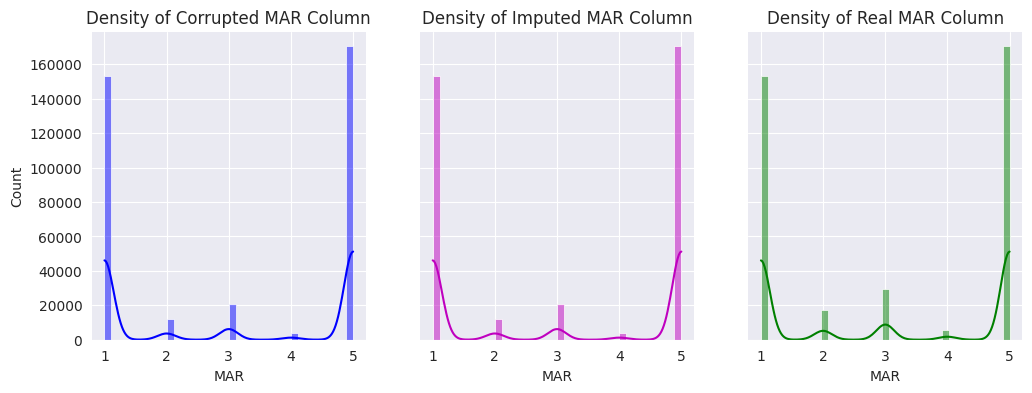





 ###############  Impute MAR column with predict-by-sklearn technique  ###############
Number of nulls in MAR column in the corrupted dataframe:  15680
Number of nulls in MAR column in the imputed dataframe:  0


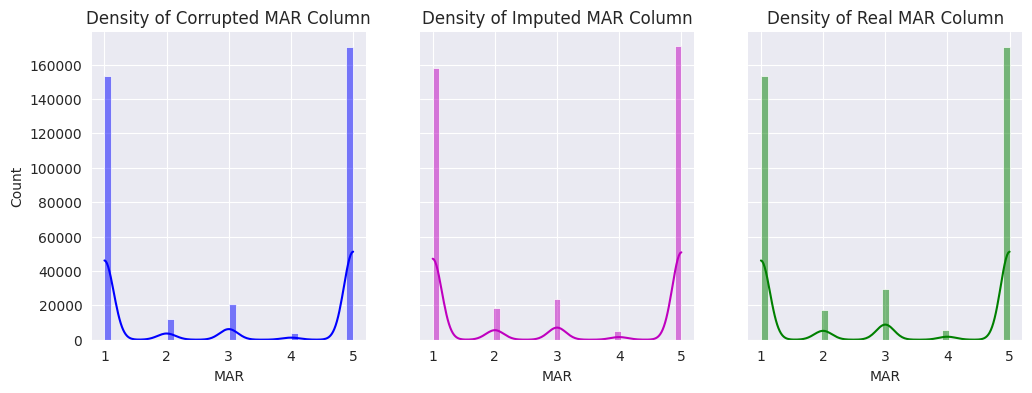





 ###############  Impute MAR column with impute-by-mode technique  ###############
Impute values:  {'MAR': 5.0}
Number of nulls in MAR column in the corrupted dataframe:  15680
Number of nulls in MAR column in the imputed dataframe:  0


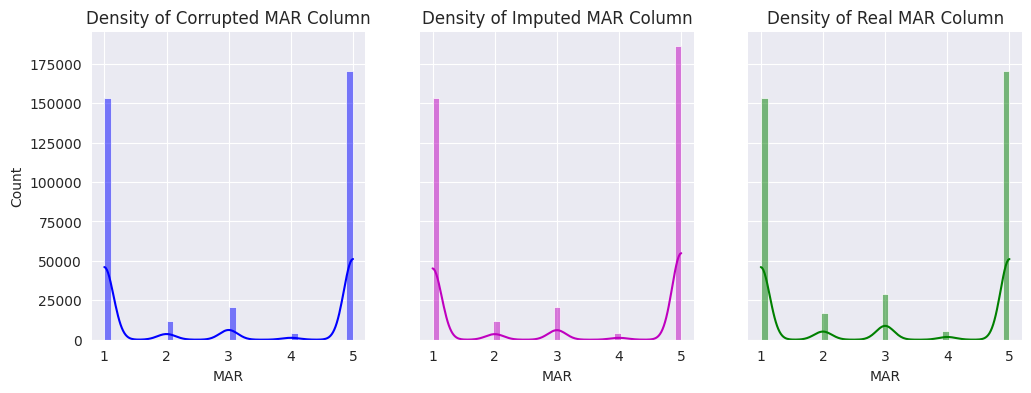





 ###############  Impute MAR column with impute-by-mode-trimmed technique  ###############
Impute values:  {'MAR': 5.0}
Number of nulls in MAR column in the corrupted dataframe:  15680
Number of nulls in MAR column in the imputed dataframe:  0


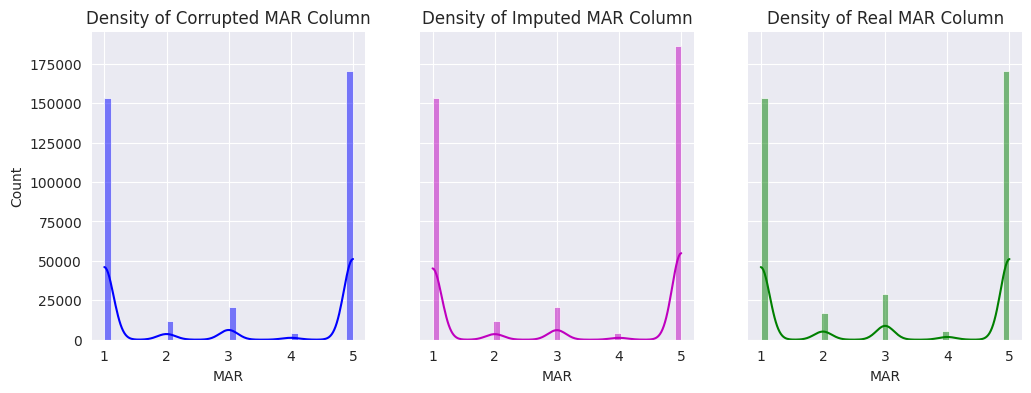





 ###############  Impute MAR column with impute-by-mode-conditional technique  ###############
Impute MAR with value 5.0, where RAC1P == 9
Impute MAR with value 5.0, where RAC1P == 7
Impute MAR with value 1.0, where RAC1P == 1
Impute MAR with value 5.0, where RAC1P == 8
Impute MAR with value 1.0, where RAC1P == 6
Impute MAR with value 5.0, where RAC1P == 2
Impute MAR with value 5.0, where RAC1P == 3
Impute MAR with value 5.0, where RAC1P == 5
Impute MAR with value 5.0, where RAC1P == 4
Number of nulls in MAR column in the corrupted dataframe:  15680
Number of nulls in MAR column in the imputed dataframe:  0


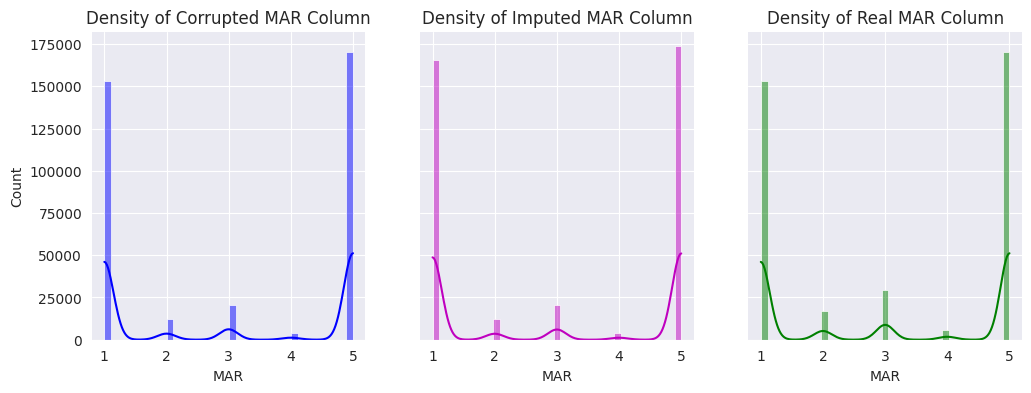

In [391]:
imputed_data_dict_MAR = impute_with_all_techniques(corrupted_data_MAR, target_column="MAR", column_type="categorical")